# <a id='title'>Оглавление</a>

### [Часть 1. Импорт библиотек / Реализация функций](#import_libs)

###  [Часть 2. Провека и подготовка датасета](#data_prep)
   > [2.1. Импорт данных](#data_prep1)  
   > [2.2. Подготовка данных](#data_prep2)   
   > [2.3. Визуализация данных](#data_prep3)  
   > [2.4. Обработка данных](#data_prep4)  

###  [Часть 3. Обучение модели](#model_train)
   > [3.1. Подбор модели](#model_train1)  
   > [3.2. Выбор метрик](#model_train2)  
   > [3.3. Обучение модели](#model_train3)
   
   
###  [Часть 4. Формирование результата](#model_final)

## Анализ задания соренования

    Задача: Построить рекомендательную систему релевантных треков для пользователей и оценить её качество.
    
    Набор данных: 
        + Провести базовую аналитику по имеющимся данным
        + Обучить модель по тексту сообщения определить, является ли её содержимое СПАМом (ожидается, что будут опробованы несколько подходов, из  которых аргументированно выбирается наилучший; можно использовать любую библиотеку или фреймворк)
        + Целевой метрикой при оценке работы модели будет ROC-AUC score
        + Произвести скрининг лучшей моделью тестовых данных, а результат записать в csv-файл в виде таблицы с колонками score и text
    
    Наборы данных представлены в формате .csv:
        - train_spam
        - test_spam

    Оценка: В качестве метрики качества использовать ROC-AUC score.

## <a id='import_libs'>Часть 1. Импорт библиотек / Реализация функций</a>
[Оглавление](#title)

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, f1_score

# Загрузка дополнительных ресурсов NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Объявление функций

In [136]:
# Инициализируем стеммер и лемматизатор
stop_words = set(stopwords.words('english'))
porter_stemmer = PorterStemmer()
word_lemmatizer = WordNetLemmatizer()

def process_text(text):
    # Токенизация текста
    tokens = word_tokenize(text.lower())
    
    # Удаление пунктуации и стоп-слов
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    
    # Стемминг и лемматизация
    stemmed_tokens = [porter_stemmer.stem(word) for word in tokens]
    lemmatized_tokens = [word_lemmatizer.lemmatize(word) for word in tokens]
    
    # Объединение обработанных токенов в строку
    processed_text = ' '.join(lemmatized_tokens)
    
    return processed_text

In [137]:
def plot_model_score(model_name, accuracy_lists, auc_lists, recall_lists, f1_lists, title):
    # Ширина столбцов
    bar_width = 0.2
    # Смещение для каждого столбца
    r1 = np.arange(1)
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]

    plt.figure(figsize=(14, 6))

    # Гистограмма для CountVectorizer
    plt.bar(r1, accuracy_lists[0],
                color='#97bad9',
                width=bar_width,
                edgecolor='black',
                label='Accuracy (Count)',
                alpha=0.7)
    
    plt.bar(r2, auc_lists[0],
                color='#bcd6ef',
                width=bar_width,
                edgecolor='black',
                label='AUC (Count)',
                alpha=0.7)
    
    plt.bar(r3, recall_lists[0],
                color='#ebcad9',
                width=bar_width,
                edgecolor='black',
                label='Recall (Count)',
                alpha=0.7)
    
    plt.bar(r4, f1_lists[0],
                color='#d5a6bd',
                width=bar_width,
                edgecolor='black',
                label='F1 (Count)',
                alpha=0.7)

    # Гистограмма для TF-IDF Vectorizer
    plt.bar(r1, accuracy_lists[1],
                color='#97bad9',
                width=bar_width,
                edgecolor='black',
                label='Accuracy (TF-IDF)',
                alpha=0.3)
    
    plt.bar(r2, auc_lists[1],
                color='#bcd6ef',
                width=bar_width,
                edgecolor='black',
                label='AUC (TF-IDF)',
                alpha=0.3)
    
    plt.bar(r3, recall_lists[1],
                color='#ebcad9',
                width=bar_width,
                edgecolor='black',
                label='Recall (TF-IDF)',
                alpha=0.3)
    
    plt.bar(r4, f1_lists[1],
                color='#d5a6bd',
                width=bar_width,
                edgecolor='black',
                label='F1 (TF-IDF)',
                alpha=0.3)

    plt.ylabel('Score')
    plt.title('{}'.format(model_name), fontweight='bold')
    plt.yticks(np.arange(0.7, 1.1, 0.1))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()


## <a id='data_prep'>Часть 2. Провека и подготовка датасета</a>
[Оглавление](#title)

### <a id='data_prep1'>2.1. Импорт данных</a>
[Оглавление](#title)

In [138]:
# Загрузим данные, а затем посмотрим на них

train = pd.read_csv('train_spam.csv')
train.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [139]:
test = pd.read_csv('test_spam.csv')
test.head()

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


### <a id='data_prep2'>2.2. Подготовка данных</a>
[Оглавление](#title)

    Раздел делится на следующие подразделы

> [2.2.1. Изучение датасета](#data_prep2.1)   
> [2.2.2. Создание новых фичей](#data_prep2.2)  

#### <a id='data_prep2.1'>2.2.1. Изучение датасета</a>
[Оглавление](#title)

In [140]:
# Посмотрим общую информация об итоговой таблице

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  16278 non-null  object
 1   text       16278 non-null  object
dtypes: object(2)
memory usage: 254.5+ KB


In [141]:
# Посмотрим на размерность датафрейма

print('В рассаматриваемом Dataframe {} строк и {} столбцов'.format(train.shape[0], train.shape[1]))

В рассаматриваемом Dataframe 16278 строк и 2 столбцов


Text(0.5, 0, 'Распредение целевой переменной')

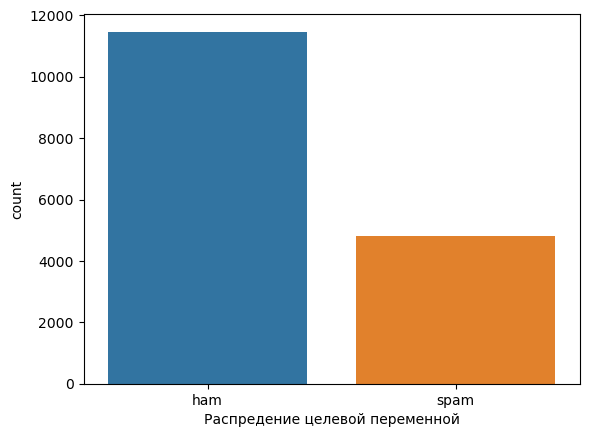

In [142]:
# Колонка text_type может принимать одно из 2 уникальных значений,
# она определяет является ли письмо СПАМом или нет


sns.countplot(data=train, x='text_type')
plt.xlabel('Распредение целевой переменной')

    Таким образом мы видим, что большинство из имеющихся писем не являются спамом

In [143]:
# Получим краткую информацию о нашем датасете

train.describe()

,text_type,text
count,16278,16278
unique,2,16267
top,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
freq,11469,7


In [144]:
# Как мы видим, в колонке text встресчается 7 раз одно и тоже письмо. Возможно повторяющихся писем больше
# Проверим это

train.duplicated().sum()

11

In [145]:
# Удалим повторяющиеся письма, из нашего датасета

train = train.drop_duplicates(keep = 'first') # Будем сохранять первое встречаемое значение

In [146]:
# По итогу наш датасет состоит из:

print('В рассаматриваемом Dataframe {} строк и {} столбцов'.format(train.shape[0], train.shape[1]))

В рассаматриваемом Dataframe 16267 строк и 2 столбцов


#### <a id='data_prep2.2'>2.2.2. Создание новых фичей</a>
[Оглавление](#title) 

In [147]:
# В качестве новых фичей сделаем следующие колонки
# - Длинна сообщения
# - Колличество слов в сообщении
# - Колличество символов в сообщении

# Длина сообщения
train['message_length'] = train['text'].apply(len)

# Количество слов в сообщении
train['word_count'] = train['text'].apply(lambda x: len(x.split()))

# Количество символов в сообщении (без учета пробелов)
train['character_count'] = train['text'].apply(lambda x: len(x.replace(" ", "")))

In [148]:
# Аналогичным образом обработаем тестовый датафрейм

# Длина сообщенияы
test['message_length'] = test['text'].apply(len)

# Количество слов в сообщении
test['word_count'] = test['text'].apply(lambda x: len(x.split()))

# Количество символов в сообщении (без учета пробелов)
test['character_count'] = test['text'].apply(lambda x: len(x.replace(" ", "")))

### <a id='data_prep3'>2.3. Визуализация данных</a>
[Оглавление](#title)

    Визуализируем следующие переменные
        - Распределение целевой перменной
        - Зависимость длинны сообщения от целевой перменной 
        - Зависимость колличества слов в сообщении от целевой перменной
        - Зависимость колличества символов в сообщении от целевой перменной

Text(0.5, 0, 'Распредение целевой переменной')

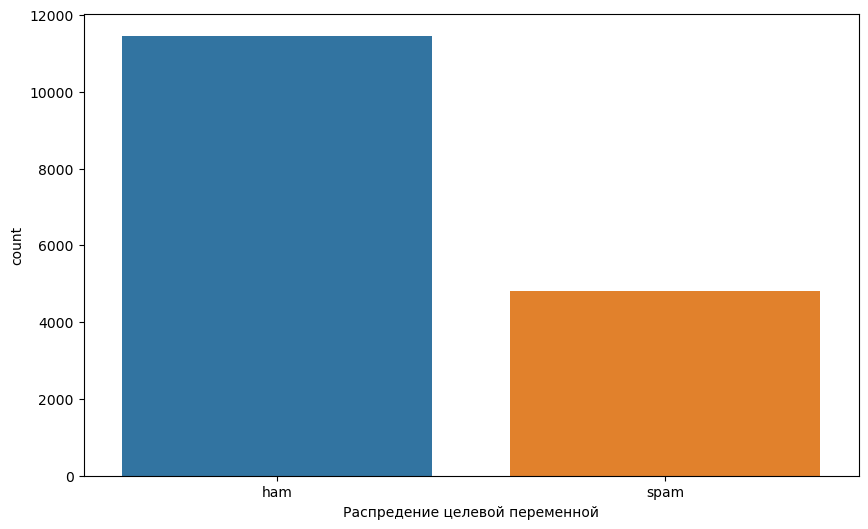

In [149]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x='text_type')
plt.xlabel('Распредение целевой переменной')

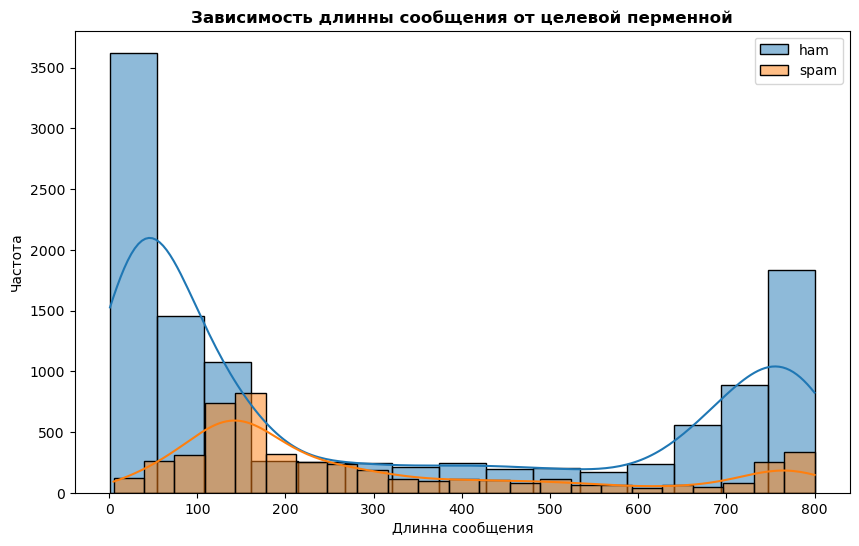

In [150]:
plt.figure(figsize=(10, 6))

# Построение гистограммы для целевого значения 'ham'
sns.histplot(train[train['text_type'] == 'ham']['message_length'], label='ham', kde=True)

# Построение гистограммы для целевого значения 'spam'
sns.histplot(train[train['text_type'] == 'spam']['message_length'], label='spam', kde=True)

# Добавление подписей и заголовка
plt.xlabel('Длинна сообщения')
plt.ylabel('Частота')
plt.title('Зависимость длинны сообщения от целевой перменной', fontweight='bold')

# Добавление легенды
plt.legend();

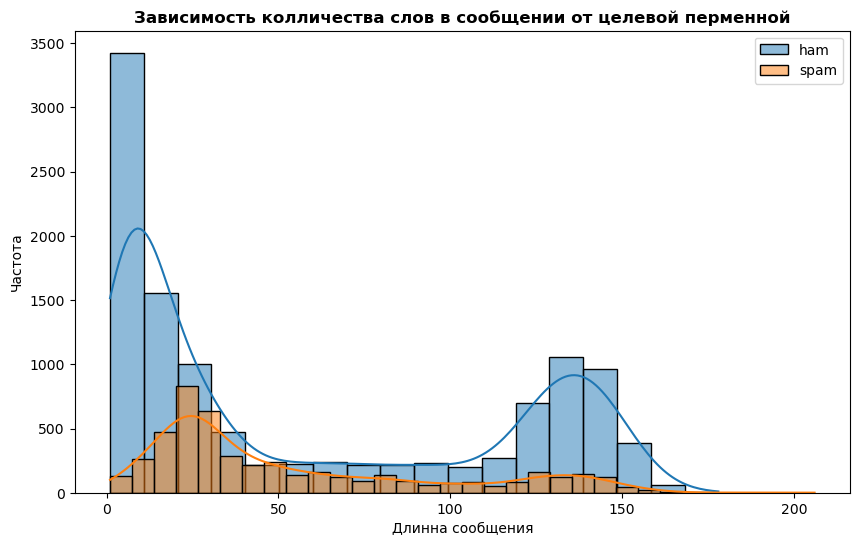

In [151]:
plt.figure(figsize=(10, 6))

# Построение гистограммы для целевого значения 'ham'
sns.histplot(train[train['text_type'] == 'ham']['word_count'], label='ham', kde=True)

# Построение гистограммы для целевого значения 'spam'
sns.histplot(train[train['text_type'] == 'spam']['word_count'], label='spam', kde=True)

# Добавление подписей и заголовка
plt.xlabel('Длинна сообщения')
plt.ylabel('Частота')
plt.title('Зависимость колличества слов в сообщении от целевой перменной', fontweight='bold')

# Добавление легенды
plt.legend();

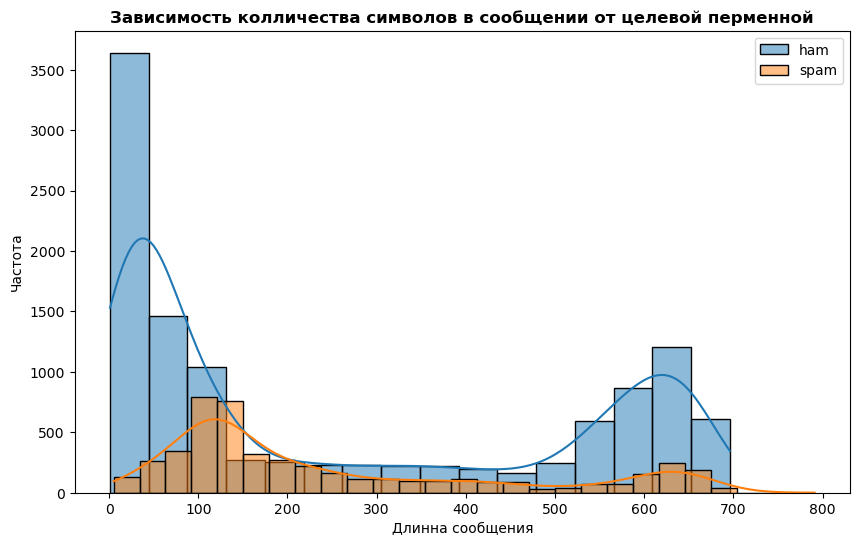

In [152]:
plt.figure(figsize=(10, 6))

# Построение гистограммы для целевого значения 'ham'
sns.histplot(train[train['text_type'] == 'ham']['character_count'], label='ham', kde=True)

# Построение гистограммы для целевого значения 'spam'
sns.histplot(train[train['text_type'] == 'spam']['character_count'], label='spam', kde=True)

# Добавление подписей и заголовка
plt.xlabel('Длинна сообщения')
plt.ylabel('Частота')
plt.title('Зависимость колличества символов в сообщении от целевой перменной', fontweight='bold')

# Добавление легенды
plt.legend();

### <a id='data_prep4'>2.4. Обработка данных</a>
[Оглавление](#title)

In [153]:
# Закодируем целевую перменную

encoder = LabelEncoder()
train['text_type'] = encoder.fit_transform(train['text_type'])

<Axes: >

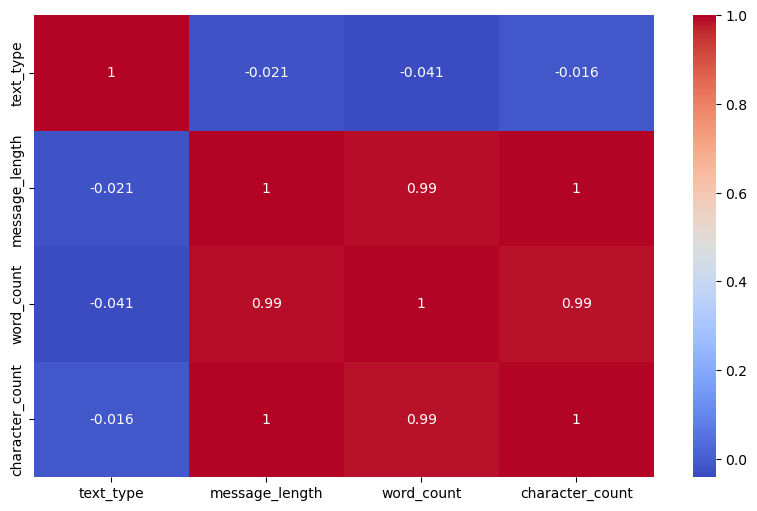

In [154]:
# Посмотрим на матрицу корреляций для нашего датафрейма

plt.figure(figsize = (10,6))
sns.heatmap(train[['text_type', 'message_length', 'word_count', 'character_count']].corr(),cmap='coolwarm',annot=True)

Теперь, приступим к обработке текста сообщений.  
Для успешной обработки нам важно выполнить следующие этапы:
   + Удаление пунктуации и стоп слов
   + Стемминг и номализация

In [155]:
# Применим написанную функцию к нашей колонке

train['text'] = train['text'].apply(process_text)
# Аналогично применим, к тестовому наборы данных
test['text_original'] = test['text']
test['text'] = test['text'].apply(process_text)

In [156]:
# Посмотрим на то, как изменились сообщения

train

,text_type,text,message_length,word_count,character_count
0,0,make sure alex know birthday fifteen minute fa...,86,16,71
1,0,resume john lavorato thanks vince get moving r...,520,97,424
2,1,plzz visit website moviesgodml get movie free ...,126,22,105
3,1,urgent mobile number awarded prize guaranteed ...,139,23,117
4,0,overview hr associate analyst project per davi...,733,127,607
...,...,...,...,...,...
16273,1,interested binary option trading may continue ...,114,18,97
16274,1,dirty pictureblyk aircel thanks valued member ...,454,73,382
16275,0,could g mon 1635465 sep 1635465 david rees wro...,799,147,653
16276,0,insta reel par 80 bhara pada hai kuch bhi dalt...,102,21,82


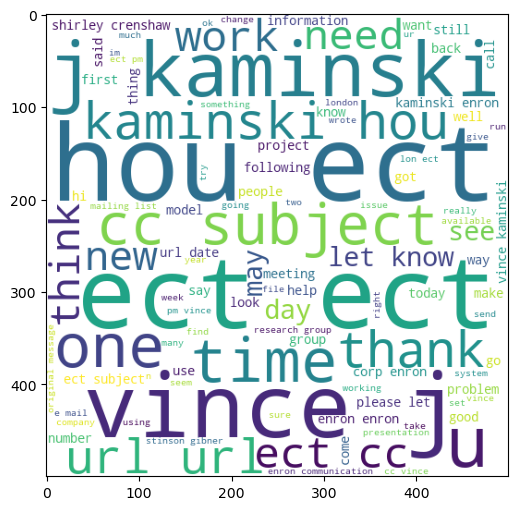

In [157]:
# WordCloud для 'ham'

wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'white')
spam_wc = wc.generate(train[train['text_type'] == 0]['text'].str.cat(sep = " "))
plt.figure(figsize = (10,6))
plt.imshow(spam_wc)
plt.show()

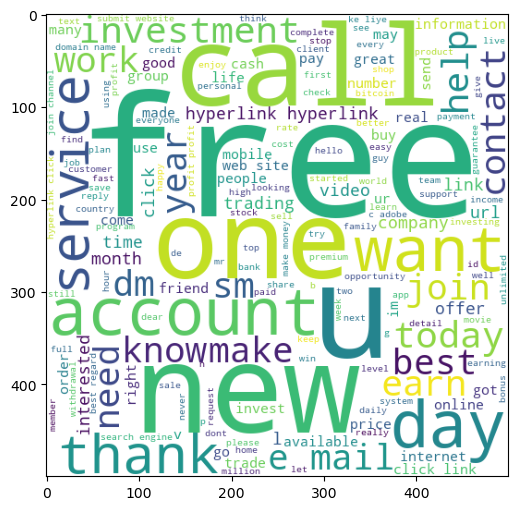

In [158]:
# WordCloud для 'spam'

wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'white')
spam_wc = wc.generate(train[train['text_type'] == 1]['text'].str.cat(sep = " "))
plt.figure(figsize = (10,6))
plt.imshow(spam_wc)
plt.show()

Теперь после того, как мы получиди инфомацию о датасете, провели обработку текста, и визуализировали некоторые фичи, приступим непосредственно к обработке сообщений 

Мы будем использовать следующие подходы:
   - *CountVectorizer* - метод преобразует коллекцию текстовых документов в матрицу подсчета токенов. (Он просто считает, сколько раз каждое слово появляется в каждом документе)
   - *TF-IDF (Term Frequency-Inverse Document Frequency)* - это статистическая мера, используемая для оценки важности слова в контексте документа, относительно корпуса документов. (Он вычисляет вес слова, учитывая частоту его встречаемости в документе и обратную частоту его встречаемости в корпусе)


In [159]:
# Разделим данные на обучающий и валидационный наборы

X_train, X_val, y_train, y_val = train_test_split(train['text'], train['text_type']
                                                                 , test_size = 0.2
                                                                 , random_state = 101
                                                                 , shuffle = True)

In [160]:
# Создадим объект CountVectorizer и преобразуем текстовые данные в признаки
count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(X_train)
X_val_counts = count_vectorizer.transform(X_val)


# Создадим объект TF-IDF Vectorizer и преобразуем текстовые данные в признаки
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

## <a id='model_train'>Часть 3. Обучение модели</a>
[Оглавление](#title)

#### <a id='model_train1'>3.1. Подбор модели</a>
[Оглавление](#title)

    В качестве базовых моделей классификации текста выберем алгоритм на основе наивного Байеса (MultinomialNB) и логистическую регрессию (LogisticRegression)

    Так же попробуем обучить такие модели как: RandomForestClassifier, SVC, GradientBoostingClassifier или XGBClassifier.

#### <a id='model_train2'>3.2. Выбор метрик</a>
[Оглавление](#title)

  + Accuracy (Точность): Метрика, которая измеряет долю правильно классифицированных примеров. Однако в случае несбалансированных классов accuracy может быть недостаточно информативной метрикой.
  + AUC-ROC (Area Under the Receiver Operating Characteristic Curve): Эта метрика оценивает качество классификации для различных значений порога классификации и позволяет оценить общую способность модели различать между классами.
  + Recall (Полнота): Это доля истинных положительных результатов, которые были корректно предсказаны моделью среди всех реальных положительных результатов. В контексте задачи спама полнота важна, потому что мы хотим минимизировать количество нераспознанных спамовых сообщений.
  + F1-score (F1-мера): Это гармоническое среднее между точностью и полнотой. 

#### <a id='model_train3'>3.3. Обучение модели</a>
[Оглавление](#title)

In [67]:
# Создадим список моделей
models = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(),
    "RandomForestClassifier": RandomForestClassifier(random_state=101),
    "SVC": SVC(probability=True, random_state=101),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=101),
    "XGBClassifier": XGBClassifier(random_state=101)
}

In [68]:
# Список для метрик с использованием CountVectorizer
accuracy_list_counts = []
auc_list_counts = []
recall_list_counts = []
f1_list_counts = []

# Обучение моделей и сбор метрик с использованием CountVectorizer
for model_name, model in models.items():
    # Обучение модели
    model.fit(X_train_counts, y_train)
    
    # Предсказание на тестовых данных
    y_pred = model.predict(X_val_counts)
    y_pred_proba = model.predict_proba(X_val_counts)[:,1]
    
    # Сбор метрик
    accuracy_list_counts.append(accuracy_score(y_val, y_pred))
    auc_list_counts.append(roc_auc_score(y_val, y_pred_proba))
    recall_list_counts.append(recall_score(y_val, y_pred))
    f1_list_counts.append(f1_score(y_val, y_pred))
    
    
# Список для метрик с использованием TF-IDF Vectorizer
accuracy_list_tfidf = []
auc_list_tfidf = []
recall_list_tfidf = []
f1_list_tfidf = []

# Обучение моделей и сбор метрик с использованием TF-IDF Vectorizer
for model_name, model in models.items():
    # Обучение модели
    model.fit(X_train_tfidf, y_train)
    
    # Предсказание на тестовых данных
    y_pred = model.predict(X_val_tfidf)
    y_pred_proba = model.predict_proba(X_val_tfidf)[:,1]
    
    # Сбор метрик
    accuracy_list_tfidf.append(accuracy_score(y_val, y_pred))
    auc_list_tfidf.append(roc_auc_score(y_val, y_pred_proba))
    recall_list_tfidf.append(recall_score(y_val, y_pred))
    f1_list_tfidf.append(f1_score(y_val, y_pred))    

In [69]:
print("Результаты обучения при использовании CountVectorizer")
print()

# Выведем метрики для CountVectorizer
for model_name, accuracy, auc, recall, f1 in zip(models.keys(),
                                                 accuracy_list_counts,
                                                 auc_list_counts,
                                                 recall_list_counts,
                                                 f1_list_counts):
    print(f"Модель: {model_name}")
    print(f"Accuracy: {accuracy}")
    print(f"AUC: {auc}")
    print(f"Recall: {recall}")
    print(f"F1 score: {f1}")
    print("-----------")
print()
    

print("Результаты обучения при использовании TF-IDF Vectorizer")
print()

# Выведем метрики для TF-IDF Vectorizer
for model_name, accuracy, auc, recall, f1 in zip(models.keys(),
                                                 accuracy_list_tfidf,
                                                 auc_list_tfidf,
                                                 recall_list_tfidf,
                                                 f1_list_tfidf):
    print(f"Модель: {model_name}")
    print(f"Accuracy: {accuracy}")
    print(f"AUC: {auc}")
    print(f"Recall: {recall}")
    print(f"F1 score: {f1}")
    print("-----------")

Результаты обучения при использовании CountVectorizer

Модель: MultinomialNB
Accuracy: 0.9164105716041795
AUC: 0.9662854402732275
Recall: 0.9065510597302505
F1 score: 0.8737233054781801
-----------
Модель: LogisticRegression
Accuracy: 0.9400737553779963
AUC: 0.9802456995193478
Recall: 0.8660886319845857
F1 score: 0.902157551430005
-----------
Модель: RandomForestClassifier
Accuracy: 0.9173325138291334
AUC: 0.9723924966785611
Recall: 0.7572254335260116
F1 score: 0.8538837588267247
-----------
Модель: SVC
Accuracy: 0.9296250768285187
AUC: 0.9740162628770965
Recall: 0.8111753371868978
F1 score: 0.880292733925771
-----------
Модель: GradientBoostingClassifier
Accuracy: 0.8460356484326982
AUC: 0.9343389815181933
Recall: 0.5510597302504817
F1 score: 0.6954407294832827
-----------
Модель: XGBClassifier
Accuracy: 0.9170251997541488
AUC: 0.9706480892162795
Recall: 0.7880539499036608
F1 score: 0.8583420776495279
-----------

Результаты обучения при использовании TF-IDF Vectorizer

Модель: Multin

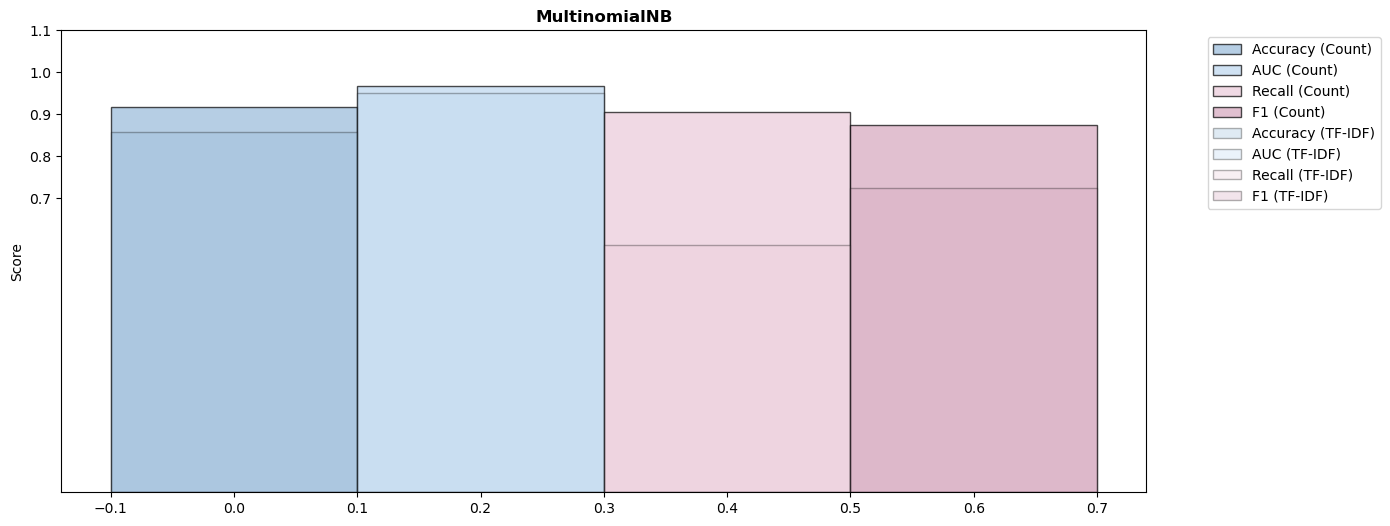

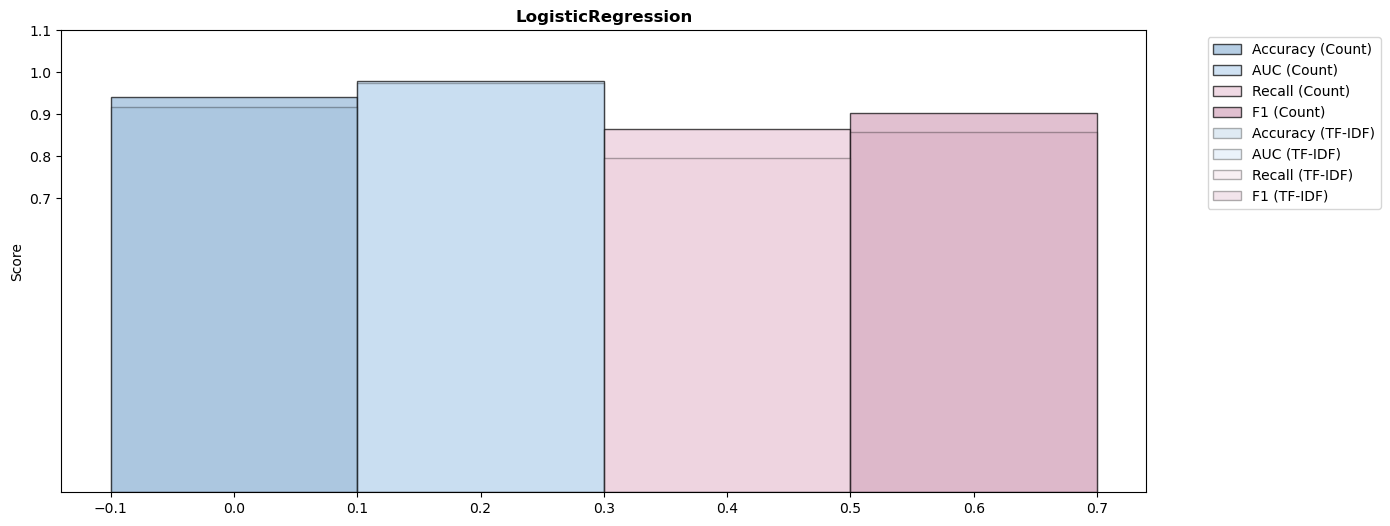

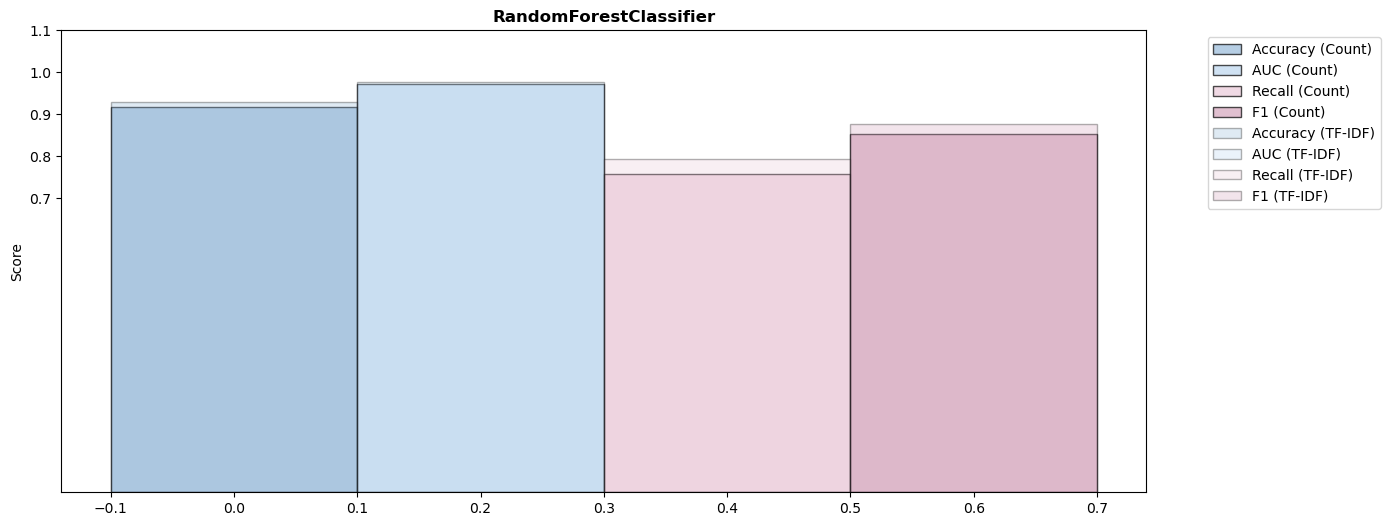

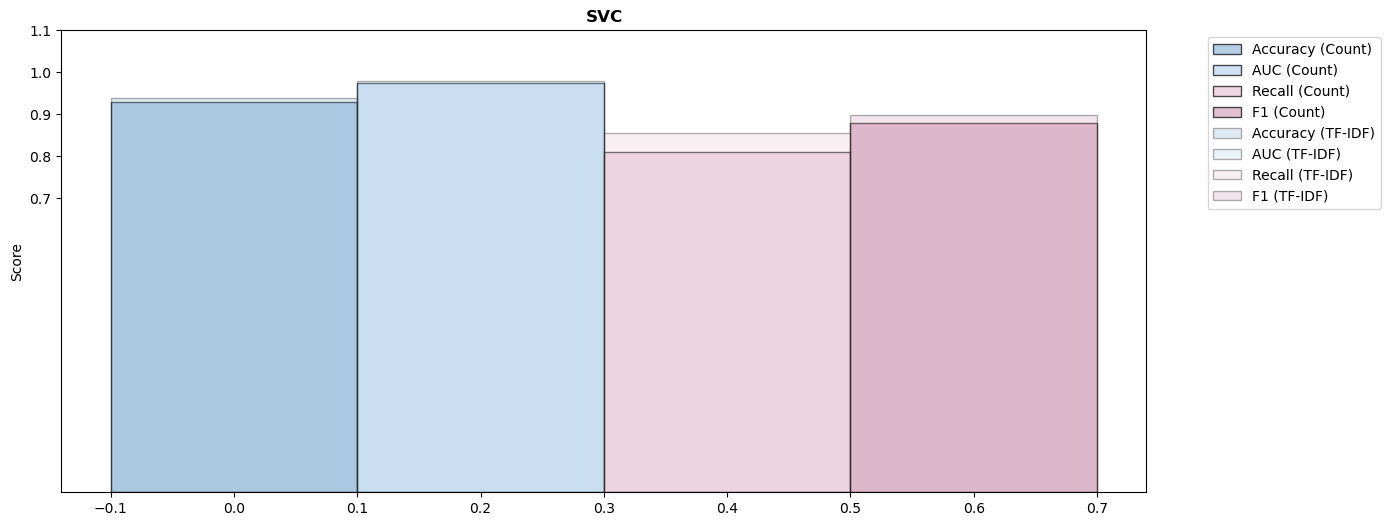

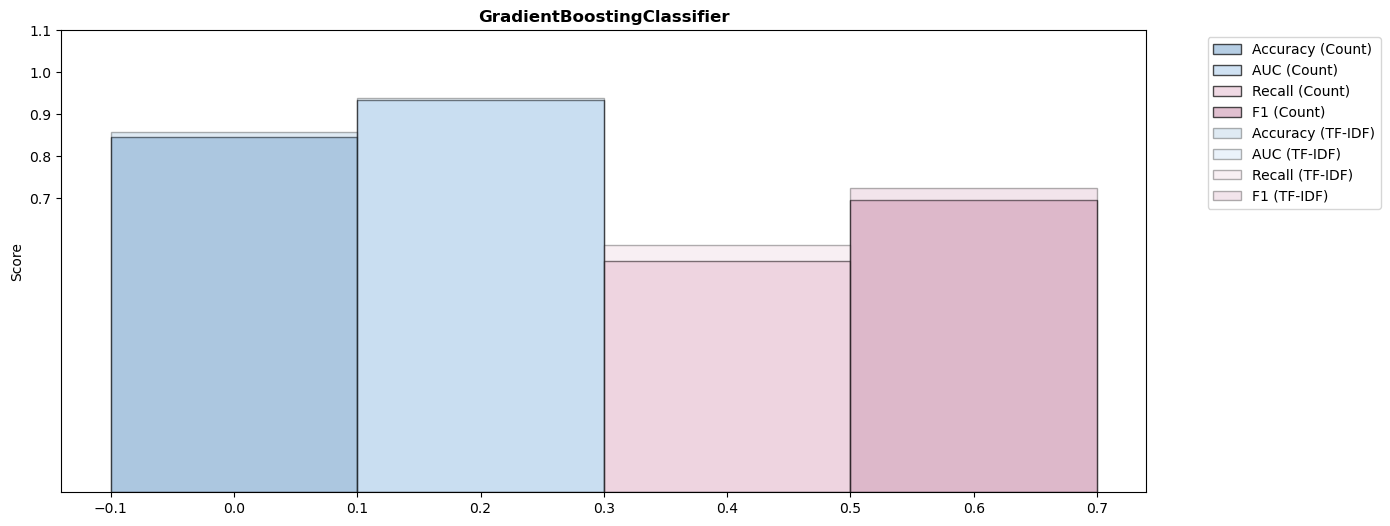

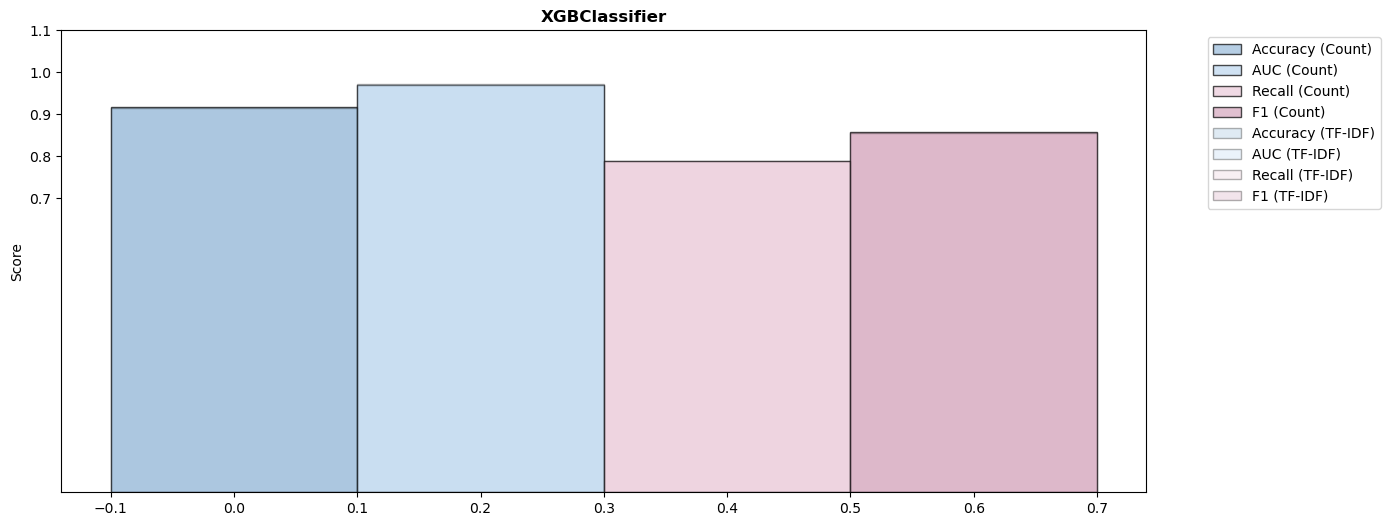

In [70]:
for i, value in enumerate(models.keys()):
    plot_model_score(value, [accuracy_list_counts[i], accuracy_list_tfidf[i]],
                            [auc_list_counts[i], auc_list_tfidf[i]],
                            [recall_list_counts[i], recall_list_tfidf[i]],
                            [f1_list_counts[i], f1_list_tfidf[i]],
                            "Model Scores")


Конечно, для повышения качетсва результатов можно попробовать подобрать гиперпараметры лучших из моделей, используя кросс-валидацию. Мы также можем построить ансамбль моделей, такой как взвешенное дерево, которое объединяет ответы нескольких моделей, что позволяет каждой модели внести свой вклад в итоговый результат. Однако, при всех этих возможностях крайне важно избегать переобучения модели.

Для формирования финального результата, я буду использовать модель LogisticRegression с использованием TF-IDF Vectorizer.
Поскольку эта модель демонстрирует высокие показатели по каждой из метрик

## <a id='model_final'>Часть 4. Формирование результата</a>
[Оглавление](#title)



In [161]:
# Инициализируем TF-IDF векторизатор
tfidf_vectorizer = TfidfVectorizer()

# Преобразуем текст вектора для обучающего и тестового набора данных
X_train_tfidf = tfidf_vectorizer.fit_transform(train['text'])
X_test_tfidf = tfidf_vectorizer.transform(test['text'])

# Инициализируем и обучаем модель Logistic Regression
lg_reg = LogisticRegression()
lg_reg.fit(X_train_tfidf, train['text_type'])

# Предсказание классов для тестового набора данных
y_pred = lg_reg.predict(X_test_tfidf)

In [162]:
# Добавляем столбец с предсказанными значениями к исходному DataFrame
test['score'] = y_pred

# Удаляем ненужные столбцы
test.drop(['text', 'message_length', 'word_count', 'character_count'], axis=1, inplace=True)
test['score'] = test['score'].replace({0: 'ham', 1: 'spam'})

test.rename(columns={'text_original':'text'})


# Сохраняем DataFrame в файл CSV
test.to_csv('submission.csv', index=False)